In [1]:
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from hierarchical_parallel_env import HierarchicalJammingEnv
import math
import random
import matplotlib.pyplot as plt

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

In [2]:
# THE PROBLEM IS IN THE SAMPLING
# SAMPLING MIGHT HAVE PARTS FROM TWO SEQUENCES INSTEAD OF ONE
# DIFFERENT AGENTS ARE SAMPLING DIFFERENT EXPERIENCES
# SAMPLE FOR ONE AGENT, FIND THE START IDX AND THEN TAKE THAT IDX FOR ALL THE AGENTS
# ALTERNATIVELY LOOK AT DATA STRUCTURES FOR STORING ENTIRE SEQUENCES

In [3]:
freq_agile_radar_versions = [[9 * math.pow(10, 8), 9.8* math.pow(10, 8)], [8 * math.pow(10, 8), 9 * math.pow(10, 8)], [6 * math.pow(10, 8), 6.8* math.pow(10, 8)]]

hop_pts = []

for i in range (0,3):
    radar_states = []
    interval = (freq_agile_radar_versions[i][1] - freq_agile_radar_versions[i][0])/18
    for j in range(0,18):
        radar_states.append(int(freq_agile_radar_versions[i][0]+ interval * j))
    hop_pts.append(radar_states)

jamming_bandwidths = [5e6, 12.5e6, 20e6]

In [4]:
diversity = 3
num_radars = len(hop_pts)
num_jammers = 6
max_steps = 20
max_hop_length = 12
num_frequencies = len(hop_pts[0])
num_bandwidths = len(jamming_bandwidths)
env = HierarchicalJammingEnv(hop_pts=hop_pts, jamming_bandwidths=jamming_bandwidths,
                              diversity=diversity, num_radars=num_radars, num_jammers=num_jammers,
                                max_steps=max_steps, max_hop_length=max_hop_length)

In [5]:
observations = env.reset()
net_reward = 0

for step in range(env.max_steps):
    print(f"Step {step + 1}")

    actions = {}
    for agent in env.agents:
        actions[agent] = {
            "radar": np.random.randint(len(env.hop_pts)),
            "frequency": np.random.randint(env.n_frequencies[0]),
            "bandwidth": np.random.randint(env.n_bandwidths)
        }

    observations, rewards, terminations, truncations, env.num_jammed_freqs, info = env.step(actions)

    for agent in env.agents:
        print(f"Agent {agent}: Observation: {observations[agent]}")
    net_reward += sum(rewards.values())
    print(f"Net reward: {net_reward}")
    if all(terminations.values()):
        print("Episode terminated.")
        break
env.close()


Step 1
Agent jammer_0: Observation: {'selected_radar': 1, 'selected_radar_frequencies': array([-2,  0,  0, -1, -1, -1, -1,  1, -1,  0,  0,  0,  0,  0,  0,  0, -2,
        0]), 'all_agents_actions': array([ 1,  6,  0,  0, 13,  1,  0,  2,  0,  1,  4,  1,  0,  4,  2,  1,  7,
        2])}
Agent jammer_1: Observation: {'selected_radar': 0, 'selected_radar_frequencies': array([ 0,  0, -1, -1, -1,  1, -1,  0,  0,  0,  0,  0, -1,  1, -1,  0, -2,
        0]), 'all_agents_actions': array([ 1,  6,  0,  0, 13,  1,  0,  2,  0,  1,  4,  1,  0,  4,  2,  1,  7,
        2])}
Agent jammer_2: Observation: {'selected_radar': 0, 'selected_radar_frequencies': array([ 0,  0, -1, -1, -1,  1, -1,  0,  0,  0,  0,  0, -1,  1, -1,  0, -2,
        0]), 'all_agents_actions': array([ 1,  6,  0,  0, 13,  1,  0,  2,  0,  1,  4,  1,  0,  4,  2,  1,  7,
        2])}
Agent jammer_3: Observation: {'selected_radar': 1, 'selected_radar_frequencies': array([-2,  0,  0, -1, -1, -1, -1,  1, -1,  0,  0,  0,  0,  0,  0,  0, -2,


In [6]:
class SequenceReplayBuffer:
    def __init__(self, capacity, sequence_length):
        """
        Args:
            capacity (int): Maximum number of transitions to store.
            sequence_length (int): Length of each sequence to sample.
        """
        self.capacity = capacity
        self.sequence_length = sequence_length
        self.buffer = []
    
    def add(self, transition):
        """
        Adds a transition to the replay buffer.
        If the capacity is exceeded, the oldest transition is removed.
        
        Args:
            transition: An experience tuple/dictionary.
        """
        self.buffer.append(transition)
        if len(self.buffer) > self.capacity:
            self.buffer.pop(0)
    
    def sample(self, batch_size):
        """
        Samples a batch of contiguous sequences from the buffer.
        
        Args:
            batch_size (int): Number of sequences to sample.
            
        Returns:
            list: A list of sequences (each a list of transitions) of length self.sequence_length.
            
        Raises:
            ValueError: If there are not enough transitions to sample a full sequence.
        """
        if len(self.buffer) < self.sequence_length:
            raise ValueError("Not enough elements in the buffer to sample a sequence")
        sequences = []
        # Calculate the maximum valid starting index
        max_start_index = len(self.buffer) - self.sequence_length
        for _ in range(batch_size):
            start_idx = np.random.randint(0, max_start_index + 1)
            sequence = self.buffer[start_idx : start_idx + self.sequence_length]
            sequences.append(sequence)
        return sequences
    
    def __len__(self):
        return len(self.buffer)

In [7]:
import unittest

class TestSequenceReplayBuffer(unittest.TestCase):
    def setUp(self):
        self.capacity = 10
        self.sequence_length = 3
        self.buffer = SequenceReplayBuffer(capacity=self.capacity, sequence_length=self.sequence_length)
    
    def test_add_and_length(self):
        # adding fewer transitions than capacity
        for i in range(5):
            self.buffer.add(i)
        self.assertEqual(len(self.buffer), 5)
        
        # adding transitions exceeding capacity should remove the oldest
        for i in range(5, 15):
            self.buffer.add(i)
        self.assertEqual(len(self.buffer), self.capacity)
        # The buffer should now hold the last 10 transitions: 5,6,...,14.
        expected = list(range(5, 15))
        self.assertEqual(self.buffer.buffer, expected)
    
    def test_sample_sequence_length(self):
        # add enough transitions to sample sequences
        for i in range(7):
            self.buffer.add(i)
        batch = self.buffer.sample(batch_size=5)
        self.assertEqual(len(batch), 5)
        for seq in batch:
            self.assertEqual(len(seq), self.sequence_length)
    
    def test_sample_not_enough_elements(self):
        # when buffer has fewer elements than sequence_length, sampling should fail.
        for i in range(self.sequence_length - 1):
            self.buffer.add(i)
        with self.assertRaises(ValueError):
            self.buffer.sample(batch_size=1)
    
    def test_sample_contiguous_sequences(self):
        # fill the buffer and check that each sampled sequence is a contiguous segment.
        transitions = list(range(15))
        for t in transitions:
            self.buffer.add(t)
        # the buffer now holds transitions [5, 6, ..., 14]
        current_buffer = self.buffer.buffer
        batch = self.buffer.sample(batch_size=20)
        for seq in batch:
            # find all possible contiguous sequences of length sequence_length
            possible_sequences = [current_buffer[i:i+self.sequence_length] for i in range(len(current_buffer)-self.sequence_length+1)]
            self.assertIn(seq, possible_sequences)

if __name__ == '__main__':
    import sys
    # reset sys.argv so that unittest doesn't try to parse Jupyter's arguments.
    sys.argv = ['']
    unittest.main(exit=False)


....
----------------------------------------------------------------------
Ran 4 tests in 0.003s

OK


In [8]:
class ActionMapper:
    def __init__(self, num_radars: int, num_frequencies: int, num_bandwidths: int):
        self.num_radars = num_radars
        self.num_frequencies = num_frequencies
        self.num_bandwidths = num_bandwidths

    def flatten_action(self, radar: int, frequency: int, bandwidth: int) -> int:
        if not (0 <= radar < self.num_radars):
            raise ValueError("Radar value out of bounds")
        if not (0 <= frequency < self.num_frequencies):
            raise ValueError("Frequency value out of bounds")
        if not (0 <= bandwidth < self.num_bandwidths):
            raise ValueError("Bandwidth value out of bounds")
        
        return (radar * self.num_frequencies * self.num_bandwidths +
                frequency * self.num_bandwidths +
                bandwidth)

    def decode_action(self, flattened_action: int) -> tuple:
        total_actions = self.num_radars * self.num_frequencies * self.num_bandwidths
        if not (0 <= flattened_action < total_actions):
            raise ValueError("Flattened action is out of bounds")
        
        radar = flattened_action // (self.num_frequencies * self.num_bandwidths)
        remaining_value = flattened_action % (self.num_frequencies * self.num_bandwidths)
        frequency = remaining_value // self.num_bandwidths
        bandwidth = remaining_value % self.num_bandwidths
        return radar, frequency, bandwidth


In [9]:
import unittest

class TestActionMapper(unittest.TestCase):
    def setUp(self):
        self.num_radars = 3
        self.num_frequencies = 4
        self.num_bandwidths = 2
        self.mapper = ActionMapper(self.num_radars, self.num_frequencies, self.num_bandwidths)

    def test_flatten_and_decode(self):
        for radar in range(self.num_radars):
            for frequency in range(self.num_frequencies):
                for bandwidth in range(self.num_bandwidths):
                    flattened = self.mapper.flatten_action(radar, frequency, bandwidth)
                    decoded = self.mapper.decode_action(flattened)
                    self.assertEqual((radar, frequency, bandwidth), decoded)

    def test_flatten_out_of_bounds(self):
        with self.assertRaises(ValueError):
            self.mapper.flatten_action(-1, 0, 0)
        with self.assertRaises(ValueError):
            self.mapper.flatten_action(self.num_radars, 0, 0)
        with self.assertRaises(ValueError):
            self.mapper.flatten_action(0, self.num_frequencies, 0)
        with self.assertRaises(ValueError):
            self.mapper.flatten_action(0, 0, self.num_bandwidths)

    def test_decode_out_of_bounds(self):
        total_actions = self.num_radars * self.num_frequencies * self.num_bandwidths
        with self.assertRaises(ValueError):
            self.mapper.decode_action(-1)
        with self.assertRaises(ValueError):
            self.mapper.decode_action(total_actions)

if __name__ == '__main__':
    import sys
    sys.argv = ['']
    unittest.main(exit=False)


.......
----------------------------------------------------------------------
Ran 7 tests in 0.005s

OK


In [10]:
class DRQN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_actions, num_layers=2):
        super(DRQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, num_layers, batch_first=True)
        self.fc2 = nn.Linear(hidden_dim, num_actions)
    
    def forward(self, x, hidden=None):
        # x shape: [batch, seq_len, input_dim]
        batch_size, seq_len, _ = x.size()
        x = F.relu(self.fc1(x))
        if hidden is None:
            lstm_out, hidden = self.lstm(x)
        else:
            lstm_out, hidden = self.lstm(x, hidden)
        q_values = self.fc2(lstm_out)
        return q_values, hidden

In [11]:
class SequenceReplayBuffer:
    def __init__(self, capacity, sequence_length):
        """
        Args:
            capacity (int): Maximum number of transitions to store.
            sequence_length (int): Length of each sequence to sample.
        """
        self.capacity = capacity
        self.sequence_length = sequence_length
        self.buffer = []
    
    def add(self, transition):
        """
        Each transition is a tuple (state, action, reward, next_state, done).
        """
        self.buffer.append(transition)
        if len(self.buffer) > self.capacity:
            self.buffer.pop(0)
    
    def sample(self, batch_size):
        """
        Samples a batch of contiguous sequences from the buffer.
        
        Args:
            batch_size (int): Number of sequences to sample.
            
        Returns:
            list: A list of sequences (each a list of transitions) of length self.sequence_length.
        Raises:
            ValueError: If there are not enough transitions to sample a full sequence.
        """
        if len(self.buffer) < self.sequence_length:
            raise ValueError("Not enough elements in the buffer to sample a sequence")
        sequences = []
        max_start = len(self.buffer) - self.sequence_length
        for _ in range(batch_size):
            start = np.random.randint(0, max_start + 1)
            seq = self.buffer[start: start + self.sequence_length]
            sequences.append(seq)
        return sequences

    def __len__(self):
        return len(self.buffer)

In [12]:
# model hyperparams
NUM_EPISODES = 400
GAMMA = 0.99
EPSILON_DECAY = 0.9995
MIN_EPSILON = 0.1
LEARNING_RATE = 1e-4
SEQUENCE_LENGTH = 160
REPLAY_CAPACITY = 20000
BATCH_SIZE = 32

diversity = 3
num_radars = len(hop_pts)
num_jammers = 9
max_steps = 1000
max_hop_length = 12
num_frequencies = len(hop_pts[0])
num_bandwidths = len(jamming_bandwidths)
env = HierarchicalJammingEnv(hop_pts=hop_pts, jamming_bandwidths=jamming_bandwidths,
                              diversity=diversity, num_radars=num_radars, num_jammers=num_jammers,
                                max_steps=max_steps, max_hop_length=max_hop_length)

action_mapper = ActionMapper(num_radars, len(hop_pts[0]), len(jamming_bandwidths))
NUM_ACTIONS = num_radars * len(hop_pts[0]) * len(jamming_bandwidths)


obs_length = len(hop_pts[0]) + 3 * len(env.agents)

HIDDEN_DIM = 256
drqn = DRQN(input_dim=obs_length, hidden_dim=HIDDEN_DIM, num_actions=NUM_ACTIONS)
optimizer = optim.Adam(drqn.parameters(), lr=LEARNING_RATE)

replay_buffers = {agent: SequenceReplayBuffer(capacity=REPLAY_CAPACITY, sequence_length=SEQUENCE_LENGTH)
                  for agent in env.agents}

epsilon = 1.0

In [13]:
def flatten_observation(obs):

    return np.concatenate([np.array(obs["selected_radar_frequencies"]).flatten(),
                           np.array(obs["all_agents_actions"]).flatten()])

In [14]:
print("Training started!")
print(env.threat_levels)
episode_jamming_freqs = np.zeros((NUM_EPISODES, len(hop_pts)))
episode_total_rewards = np.zeros(NUM_EPISODES)
episode_avg_rewards = np.zeros(NUM_EPISODES)
episode_losses = np.zeros(NUM_EPISODES)
for episode in range(NUM_EPISODES):

    observations, _ = env.reset()
    agent_obs = {agent: flatten_observation(observations[agent]) for agent in env.agents}
    episode_rewards = {agent: 0 for agent in env.agents}
    done_flags = {agent: False for agent in env.agents}
    step_count = 0

    episode_transitions = {agent: [] for agent in env.agents}

    while not all(done_flags.values()):
        actions = {}
        for agent in env.agents:
            if done_flags[agent]:
                actions[agent] = {"radar": 0, "frequency": 0, "bandwidth": 0}
                continue

            if random.random() < epsilon:
                action_index = random.randint(0, NUM_ACTIONS - 1)
            else:
                state_tensor = torch.FloatTensor(agent_obs[agent]).unsqueeze(0).unsqueeze(0)
                with torch.no_grad():
                    q_values, _ = drqn(state_tensor)
                q_values = q_values.squeeze(0).squeeze(0)
                action_index = q_values.argmax().item()
            radar, frequency, bandwidth = action_mapper.decode_action(action_index)
            actions[agent] = {"radar": radar, "frequency": frequency, "bandwidth": bandwidth}
        
        next_observations, rewards, terminations, truncations, env.num_jammed_freqs, info = env.step(actions)
        #for each radar, get the count of 1s in env.num_jammed_freqs and store it in episode_jamming_freqs
        for i in range(0, len(hop_pts)):
            episode_jamming_freqs[episode][i] += np.count_nonzero(env.num_jammed_freqs[i])
        env.num_jammed_freqs = np.zeros((len(hop_pts), len(hop_pts[0])))


        next_agent_obs = {}
        for agent in env.agents:
            next_obs = flatten_observation(next_observations[agent])
            next_agent_obs[agent] = next_obs
            reward = rewards[agent]
            done = terminations[agent] or truncations[agent]
            episode_rewards[agent] += reward

            transition = (agent_obs[agent], 
                          action_mapper.flatten_action(actions[agent]["radar"],
                                                       actions[agent]["frequency"],
                                                       actions[agent]["bandwidth"]),
                          reward,
                          next_obs,
                          done)
            episode_transitions[agent].append(transition)
            done_flags[agent] = done

        agent_obs = next_agent_obs
        step_count += 1

    for agent in env.agents:
        for trans in episode_transitions[agent]:
            replay_buffers[agent].add(trans)

    total_loss = 0.0
    num_updates = 0
    for agent in env.agents:
        if len(replay_buffers[agent]) >= SEQUENCE_LENGTH:
            try:
                sequences = replay_buffers[agent].sample(BATCH_SIZE)
            except ValueError:
                continue

            batch_states = []
            batch_actions = []
            batch_rewards = []
            batch_next_states = []
            batch_dones = []

            for seq in sequences:
                states_seq = [s for (s, a, r, ns, d) in seq]
                actions_seq = [a for (s, a, r, ns, d) in seq]
                rewards_seq = [r for (s, a, r, ns, d) in seq]
                next_states_seq = [ns for (s, a, r, ns, d) in seq]
                dones_seq = [d for (s, a, r, ns, d) in seq]

                batch_states.append(states_seq)
                batch_actions.append(actions_seq)
                batch_rewards.append(rewards_seq)
                batch_next_states.append(next_states_seq)
                batch_dones.append(dones_seq)

            # Convert batches to tensors.
            state_tensor = torch.FloatTensor(np.array(batch_states))
            action_tensor = torch.LongTensor(np.array(batch_actions))
            reward_tensor = torch.FloatTensor(np.array(batch_rewards))
            next_state_tensor = torch.FloatTensor(np.array(batch_next_states))
            done_tensor = torch.FloatTensor(np.array(batch_dones))

            q_values, _ = drqn(state_tensor)
            q_values = q_values.gather(2, action_tensor.unsqueeze(-1)).squeeze(-1)

            with torch.no_grad():
                next_q_values, _ = drqn(next_state_tensor)
                next_q_max, _ = next_q_values.max(dim=2)
                target_q = reward_tensor + GAMMA * next_q_max * (1 - done_tensor)

            loss = F.mse_loss(q_values, target_q)
            total_loss += loss
            num_updates += 1

    if num_updates > 0:
        optimizer.zero_grad()
        (total_loss / num_updates).backward()
        optimizer.step()

    epsilon = max(MIN_EPSILON, epsilon * EPSILON_DECAY)
    episode_total_rewards[episode] = np.sum(list(episode_rewards.values()))
    episode_avg_rewards[episode] = np.mean(list(episode_rewards.values()))
    episode_losses[episode] = total_loss.item() if num_updates > 0 else 0

    
    if (episode + 1) % 10 == 0:
        avg_reward = np.mean(list(episode_rewards.values()))
        sum_rewards = np.sum(list(episode_rewards.values()))
        print(f"Episode {episode+1}/{NUM_EPISODES}, Avg Reward: {avg_reward:.2f}, Total Reward: {sum_rewards:.2f}, Jamming Fraction: {episode_jamming_freqs[episode]/(diversity*max_steps)}")

print("Training complete!")

Training started!
[3.75 2.5  3.75]
Episode 10/400, Avg Reward: -4.77, Total Reward: -42.96, Jamming Fraction: [0.39633333 0.32233333 0.383     ]
Episode 20/400, Avg Reward: -4.51, Total Reward: -40.61, Jamming Fraction: [0.39733333 0.32033333 0.40266667]
Episode 30/400, Avg Reward: -4.34, Total Reward: -39.05, Jamming Fraction: [0.42633333 0.30133333 0.36833333]
Episode 40/400, Avg Reward: -4.55, Total Reward: -40.95, Jamming Fraction: [0.406      0.31433333 0.36966667]
Episode 50/400, Avg Reward: -3.86, Total Reward: -34.74, Jamming Fraction: [0.40533333 0.32666667 0.38666667]
Episode 60/400, Avg Reward: -3.24, Total Reward: -29.14, Jamming Fraction: [0.40933333 0.328      0.38      ]
Episode 70/400, Avg Reward: -4.90, Total Reward: -44.06, Jamming Fraction: [0.41766667 0.30833333 0.356     ]
Episode 80/400, Avg Reward: -4.69, Total Reward: -42.18, Jamming Fraction: [0.40033333 0.319      0.37166667]
Episode 90/400, Avg Reward: -4.07, Total Reward: -36.59, Jamming Fraction: [0.3776666

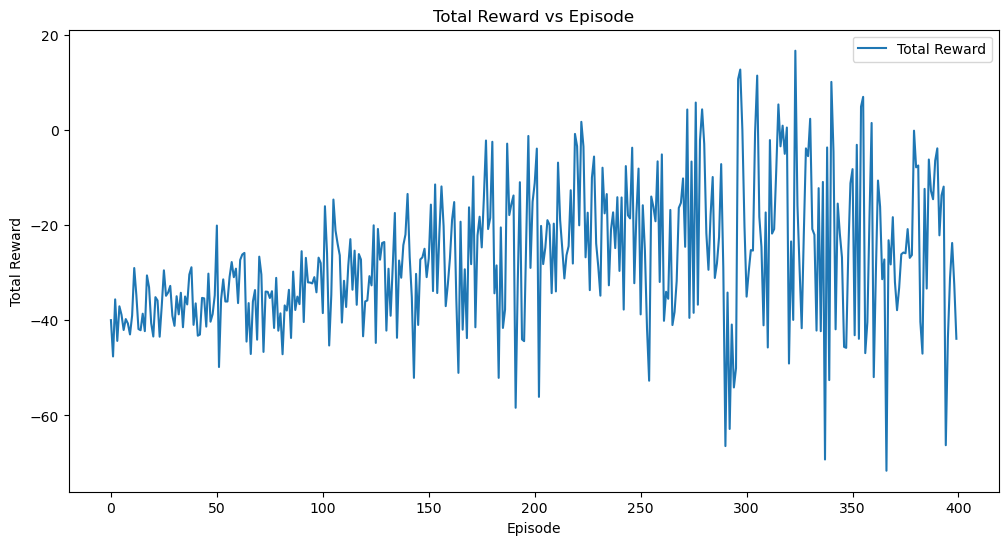

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(episode_total_rewards, label="Total Reward")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Reward vs Episode")
plt.legend()

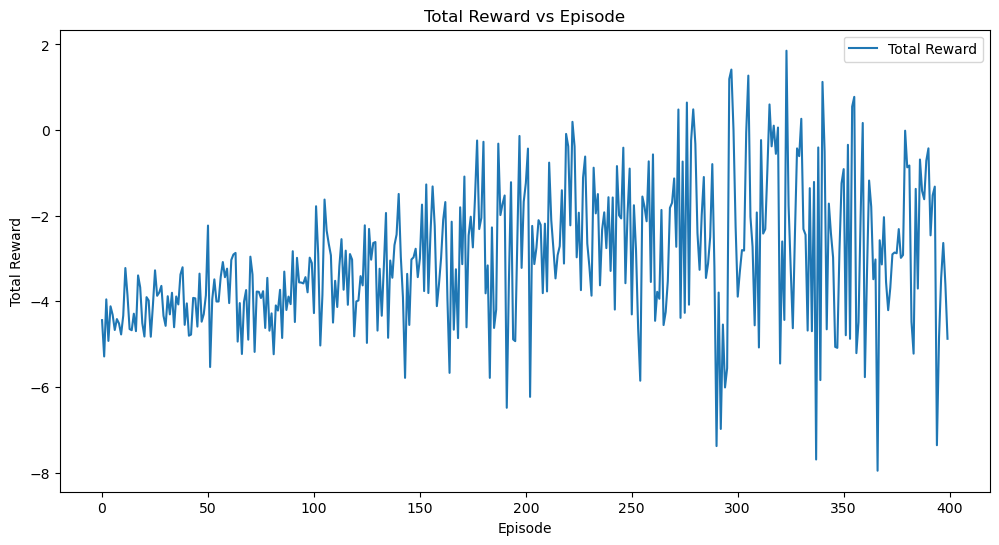

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(episode_avg_rewards, label="Total Reward")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Reward vs Episode")
plt.legend()

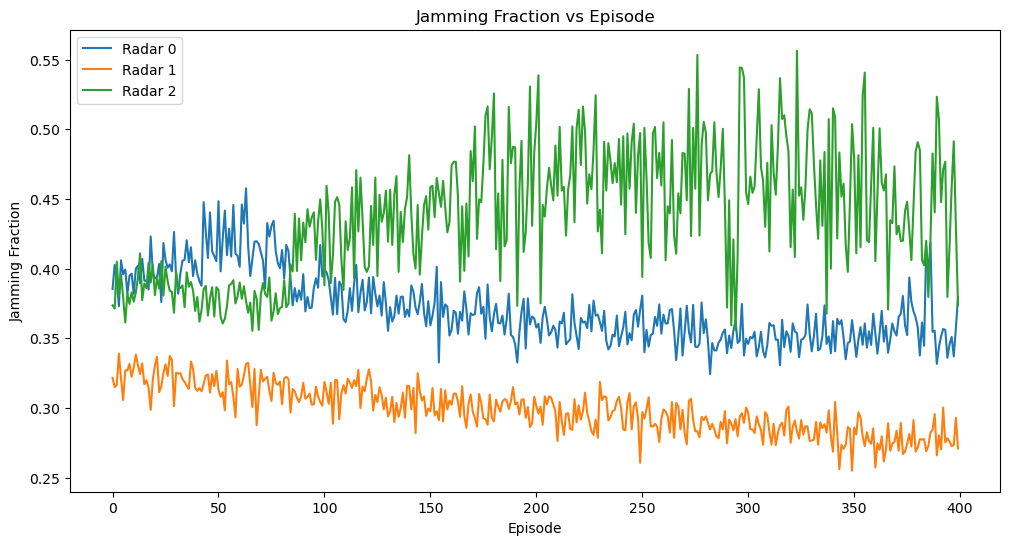

In [17]:
jamming_fractions = episode_jamming_freqs / (diversity * max_steps)
plt.figure(figsize=(12, 6))
for i in range(len(hop_pts)):
    plt.plot(jamming_fractions[:,i], label=f"Radar {i}")
plt.xlabel("Episode")
plt.ylabel("Jamming Fraction")
plt.title("Jamming Fraction vs Episode")
plt.legend()

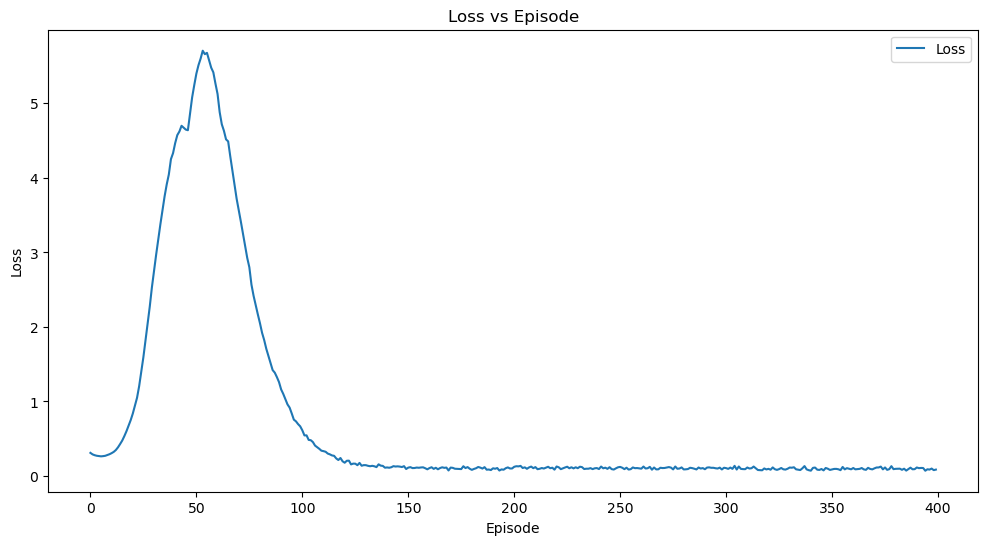

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(episode_losses, label="Loss")
plt.xlabel("Episode")
plt.ylabel("Loss")
plt.title("Loss vs Episode")
plt.legend()